In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
    
import pickle

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *
from src.evaluation import *
from src.regrid import *

In [4]:
DATADRIVE = '/home/jupyter/data/'

## Load datasets

In [5]:
# # Using first few days of every month of 2020, eventually use all of 2020
ds_test = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-12'),
    scale=False,
    first_days=5,
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
# # Using first few days of every month of 2020, eventually use all of 2020
ds_test_ens = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation_ens10'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-12'),
    scale=False,
    first_days=5,
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


## Get mask

In [7]:
ds = xr.open_dataset(
    '/home/jupyter/data/hrrr/raw/total_precipitation/20180215_00.nc')

In [8]:
ds_regridded = regrid(ds, 4, lons=(235, 290), lats=(50, 20))[0]

Creating new regridder


/opt/conda/envs/ilan/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [9]:
hrrr_mask = np.isfinite(ds_regridded).tp.isel(init_time=0, lead_time=0)

In [10]:
rq = xr.open_dataarray(f'{DATADRIVE}/mrms/4km/RadarQuality.nc')
mrms_mask = rq>-1
mrms_mask = mrms_mask.assign_coords({
    'lat': hrrr_mask.lat,
    'lon': hrrr_mask.lon
})

In [11]:
total_mask = mrms_mask * hrrr_mask

In [12]:
# total_mask = total_mask.isel(lat=slice(0, -6))

In [13]:
total_mask = total_mask.assign_coords({'lat': ds_test.mrms.lat.values, 'lon': ds_test.mrms.lon.values})

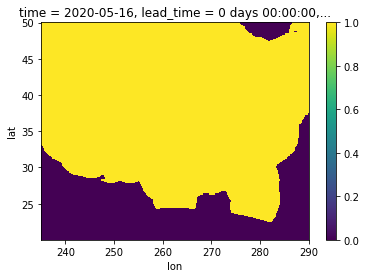

In [14]:
total_mask.plot()

In [15]:
total_mask.to_netcdf('tmp/total_mask.nc')

## MRMS

In [16]:
mrms = ds_test.mrms.rename({'time': 'valid_time'}).where(total_mask)

In [17]:
mrms = mrms.isel(valid_time=slice(3, None))

## Interpolation baseline

In [18]:
tigge = ds_test.tigge.isel(variable=0)
tigge_ens = ds_test_ens.tigge.isel(variable=0)

In [19]:
interp = tigge.interp_like(mrms, method='linear').where(total_mask)
interp_ens = tigge_ens.interp_like(mrms, method='linear').where(total_mask)

In [20]:
# To match HREF valid times
interp = interp.isel(valid_time=slice(1, None))
interp_ens = interp_ens.isel(valid_time=slice(1, None))

## HRRR baseline

In [21]:
fn = f'{DATADRIVE}/hrrr/4km/total_precipitation/2020*.nc'
hrrr = xr.open_mfdataset(fn)

In [22]:
hrrr = hrrr.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [23]:
hrrr['valid_time'] = hrrr.init_time + hrrr.lead_time
hrrr = hrrr.swap_dims({'init_time': 'valid_time'})

In [24]:
hrrr = hrrr.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

In [25]:
hrrr = hrrr.sel(valid_time=interp.valid_time).where(total_mask)

In [26]:
hrrr.load()

<xarray.DataArray 'tp' (valid_time: 106, lat: 750, lon: 1376)>
array([[[ 4.0390790e-03,  6.4396262e-03,  1.4563143e-02, ...,
          4.7163504e-01,  3.1052601e-01,  1.6147426e-01],
        [ 1.8984914e-02,  2.0336092e-02,  2.6811540e-02, ...,
          5.7891089e-01,  5.6164551e-01,  5.1993197e-01],
        [ 7.5867176e-02,  7.9427123e-02,  8.1701636e-02, ...,
          5.3167963e-01,  5.1318002e-01,  4.9433398e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[ 6.8620634e-01,  1.2065198e+00,  1.7260882e+00, ...,
          6.4454758e-01,  4.3683308e-01,  2.3475526e-01],
        [ 2.2707477e+00,  2.2326407e+00,  2.2252786e+00, ...,
          1.0418494e+00,  9.2378813e-01,  8.3333009e-01],
        [ 2.8631575e+00,  2.7728269e+00,  2.7656128e+00, ...,
          1.5000882e+00,  1.3637257e+00,  1.2297558e+00],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * valid_time  (valid_time) datetime64[ns] 2020-01-03T12:00:00 ... 2020-12-0...
    variable    <U2 'tp'
    time        datetime64[ns] 2020-05-16

## HREF baseline

In [28]:
href = xr.open_mfdataset('/home/jupyter/data/hrefv2//4km/total_precipitation/2020*.nc')

In [29]:
href = href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [30]:
href['valid_time'] = href.init_time + href.lead_time
href = href.swap_dims({'init_time': 'valid_time'})

In [31]:
href

,Array,Chunk
Bytes,27.91 GiB,39.37 MiB
Shape,"(10, 726, 750, 1376)","(10, 1, 750, 1376)"
Count,5082 Tasks,726 Chunks
Type,float32,numpy.ndarray


In [32]:
href = href.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

In [33]:
href

,Array,Chunk
Bytes,27.91 GiB,39.37 MiB
Shape,"(10, 726, 750, 1376)","(10, 1, 750, 1376)"
Count,5082 Tasks,726 Chunks
Type,float32,numpy.ndarray


In [34]:
href = href.sel(valid_time=interp.valid_time).where(total_mask)

In [35]:
href

,Array,Chunk
Bytes,4.08 GiB,39.37 MiB
Shape,"(10, 106, 750, 1376)","(10, 1, 750, 1376)"
Count,5295 Tasks,106 Chunks
Type,float32,numpy.ndarray


In [36]:
href.load()

<xarray.DataArray 'tp' (member: 10, valid_time: 106, lat: 750, lon: 1376)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 1.00300908e+00,  1.00300908e+00,  1.00300908e+00, ...,
           8.75647783e-01,  1.96758479e-01,  0.00000000e+00],
         [ 1.00300908e+00,  1.00300908e+00,  1.00300908e+00, ...,
           1.17107719e-01,  6.12601563e-02,  0.00000000e+00],
         [ 1.00300908e+00,  1.00300908e+00,  1.50343823e+00, ...,
           9.58983004e-01,  6.74998045e-01,  9.07833651e-02],
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
    surface     float64 0.0
  * valid_time  (valid_time) datetime64[ns] 2020-01-03T12:00:00 ... 2020-12-0...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'
    variable    <U2 'tp'

## Save intermediate arrays

In [32]:
!mkdir -p tmp

In [37]:
mrms.to_netcdf('tmp/mrms.nc')
interp.to_netcdf('tmp/interp.nc')
interp_ens.to_netcdf('tmp/interp_ens.nc')
hrrr.to_netcdf('tmp/hrrr.nc')
href.to_netcdf('tmp/href.nc')

In [42]:
mrms = mrms.sel(valid_time=href.valid_time)

In [ ]:
mrms = xr.load_dataarray('tmp/mrms.nc')
interp= xr.load_dataarray('tmp/interp.nc')
interp_ens= xr.load_dataarray('tmp/interp_ens.nc')
hrrr= xr.load_dataarray('tmp/hrrr.nc')
href= xr.load_dataarray('tmp/href.nc')

## Compute scores

### Mean RMSE

In [43]:
xs.rmse(interp, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.17504735)

In [44]:
xs.rmse(hrrr, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(3.075337, dtype=float32)

In [45]:
xs.rmse(interp_ens.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.05458457)

In [46]:
xs.rmse(href.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(2.0970209, dtype=float32)

### CRPS

In [47]:
xs.crps_ensemble(mrms, href, dim=['lat', 'lon', 'valid_time']).values

array(0.34303965)

In [44]:
xs.crps_ensemble(mrms, interp_ens, dim=['lat', 'lon', 'valid_time']).values

array(0.37556464)

### Reliability diagram

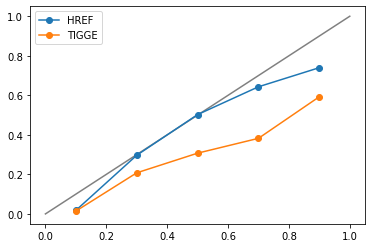

In [54]:
threshold = 1
rel_href = xs.reliability(mrms>threshold, (href>threshold).mean('member'))
rel_interp = xs.reliability(mrms>threshold, (interp_ens>threshold).mean('member'))
plt.plot([0, 1], [0, 1], c='gray')
plt.plot(rel_href.forecast_probability, rel_href, marker='o', label='HREF')
plt.plot(rel_interp.forecast_probability, rel_interp, marker='o', label='TIGGE')
plt.legend()

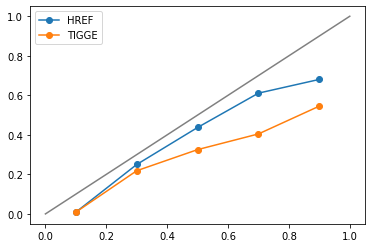

In [58]:
threshold = 4
rel_href = xs.reliability(mrms>threshold, (href>threshold).mean('member'))
rel_interp = xs.reliability(mrms>threshold, (interp_ens>threshold).mean('member'))
plt.plot([0, 1], [0, 1], c='gray')
plt.plot(rel_href.forecast_probability, rel_href, marker='o', label='HREF')
plt.plot(rel_interp.forecast_probability, rel_interp, marker='o', label='TIGGE')
plt.legend()

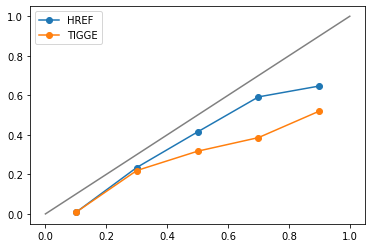

In [55]:
threshold = 5
rel_href = xs.reliability(mrms>threshold, (href>threshold).mean('member'))
rel_interp = xs.reliability(mrms>threshold, (interp_ens>threshold).mean('member'))
plt.plot([0, 1], [0, 1], c='gray')
plt.plot(rel_href.forecast_probability, rel_href, marker='o', label='HREF')
plt.plot(rel_interp.forecast_probability, rel_interp, marker='o', label='TIGGE')
plt.legend()

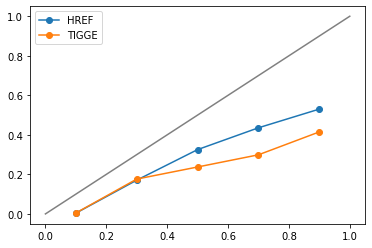

In [56]:
threshold = 10
rel_href = xs.reliability(mrms>threshold, (href>threshold).mean('member'))
rel_interp = xs.reliability(mrms>threshold, (interp_ens>threshold).mean('member'))
plt.plot([0, 1], [0, 1], c='gray')
plt.plot(rel_href.forecast_probability, rel_href, marker='o', label='HREF')
plt.plot(rel_interp.forecast_probability, rel_interp, marker='o', label='TIGGE')
plt.legend()

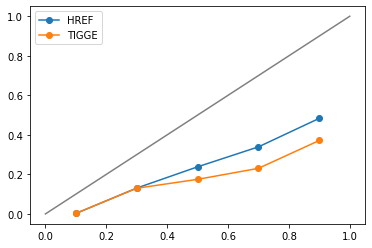

In [57]:
threshold = 15
rel_href = xs.reliability(mrms>threshold, (href>threshold).mean('member'))
rel_interp = xs.reliability(mrms>threshold, (interp_ens>threshold).mean('member'))
plt.plot([0, 1], [0, 1], c='gray')
plt.plot(rel_href.forecast_probability, rel_href, marker='o', label='HREF')
plt.plot(rel_interp.forecast_probability, rel_interp, marker='o', label='TIGGE')
plt.legend()

## Brier score

In [48]:
threshold = 1
xs.brier_score(mrms>threshold, (href>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.03527073)

In [49]:
threshold = 1
xs.brier_score(mrms>threshold, (interp_ens>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.04156869)

In [50]:
threshold = 5
xs.brier_score(mrms>threshold, (href>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.01379816)

In [51]:
threshold = 5
xs.brier_score(mrms>threshold, (interp_ens>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.01574615)

In [52]:
threshold = 10
xs.brier_score(mrms>threshold, (href>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

array(0.0065873)

In [ ]:
threshold = 10
xs.brier_score(mrms>threshold, (interp_ens>threshold).mean('member'), dim=['lat', 'lon', 'valid_time']).values

## Some figures

In [107]:
time = '2020-05-01T00'

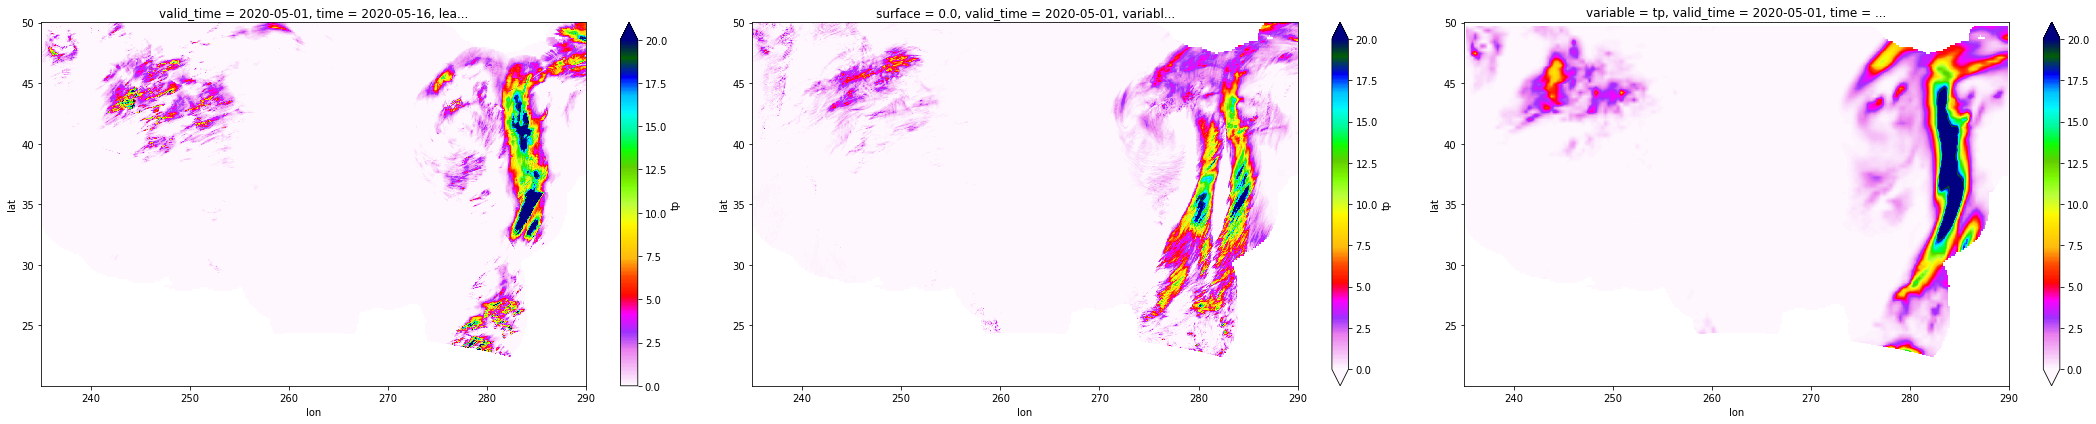

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
mrms.sel(valid_time=time).plot(vmin=0, vmax=20, cmap='gist_ncar_r', ax=ax1)
href.sel(valid_time=time).mean('member').plot(vmin=0, vmax=20, cmap='gist_ncar_r', ax=ax2)
interp_ens.sel(valid_time=time).mean('member').plot(vmin=0, vmax=20, cmap='gist_ncar_r', ax=ax3)
plt.tight_layout()

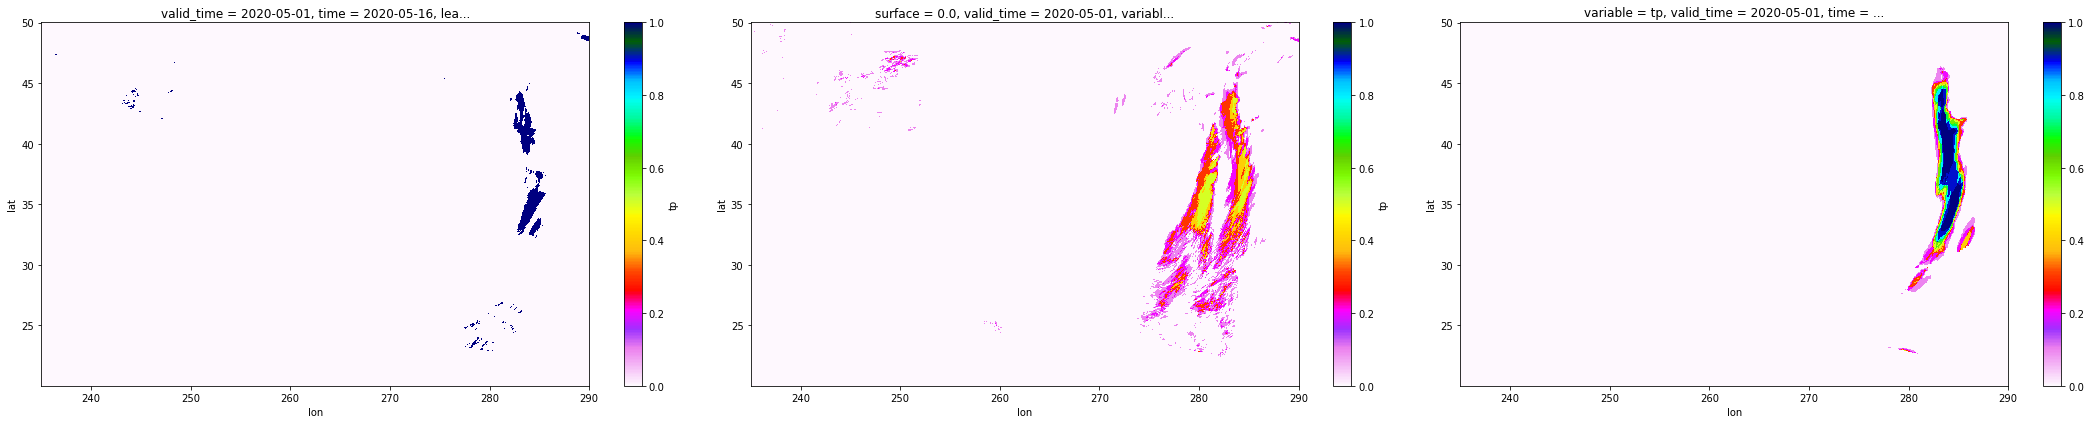

In [109]:
thresh=15
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))
(mrms > thresh).sel(valid_time=time).plot(vmin=0, vmax=1, cmap='gist_ncar_r', ax=ax1)
(href > thresh).sel(valid_time=time).mean('member').plot(vmin=0, vmax=1, cmap='gist_ncar_r', ax=ax2)
(interp_ens > thresh).sel(valid_time=time).mean('member').plot(vmin=0, vmax=1, cmap='gist_ncar_r', ax=ax3)
plt.tight_layout()

### Thresholded RMSE

In [ ]:
def thresh_rmse(a, b, thresh):
    a_thresh = a > thresh
    b_thresh = b > thresh
    

In [7]:
rq = xr.open_dataarray('/datadrive_ssd/mrms/4km/RadarQuality.nc')
eval_mask = rq>-1
fn = "/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/RadarOnly_QPE_06H_00.00_20180101-000000.nc"
ds = xr.open_dataset(fn)
assert eval_mask.lat.shape ==ds.lat.shape
eval_mask['lat'] = ds.lat 
assert eval_mask.lon.shape ==ds.lon.shape
eval_mask['lon'] = ds.lon

In [8]:
mrms = ds_test.mrms.rename(
    {'time': 'valid_time'})
mrms = mrms.where(eval_mask)

In [9]:
tigge = ds_test.tigge.isel(variable=0)

In [10]:
interp = tigge.interp_like(mrms, method='linear')

In [11]:
mrms.chunk({'valid_time': 1})

<xarray.DataArray 'tp' (valid_time: 44, lat: 750, lon: 1376)>
dask.array<xarray-<this-array>, shape=(44, 750, 1376), dtype=float64, chunksize=(1, 750, 1376), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
    lead_time   timedelta64[ns] 12:00:00
    time        datetime64[ns] ...

In [12]:
interp

<xarray.DataArray (valid_time: 44, lat: 750, lon: 1376)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    variable    <U2 'tp'
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

In [28]:
mrms_pert = mrms + np.random.normal(scale=1e-6, size=mrms.shape)
interp_pert = interp + np.random.normal(scale=1e-6, size=interp.shape)

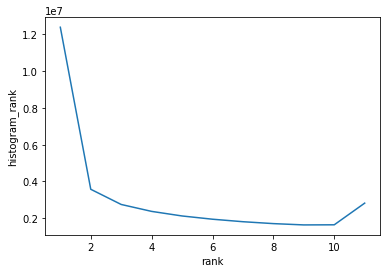

In [29]:
xs.rank_histogram(mrms_pert.chunk({'valid_time': 1}), interp_pert.chunk({'valid_time': 1})).compute().plot()

In [30]:
xs.crps_ensemble(mrms, interp)

<xarray.DataArray ()>
array(0.3749019)
Coordinates:
    time       datetime64[ns] 2020-05-16
    lead_time  timedelta64[ns] 12:00:00
    variable   <U2 'tp'

## HRRR

In [ ]:
!ls /datadrive_ssd/